In [55]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy.stats as stats
import random as rand
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
from IPython.display import Image
import matplotlib.ticker as mtick
style.use("fivethirtyeight")

In [3]:
%load_ext autoreload
%autoreload 2

### 1. PERMUTATION TESTS

### a. Bernoulli Trials: ¿Esta cargada una moneda simulada?

In [4]:
import numpy as np

np.rand.seed(1)
np.rand.binomial(1, 0.5, 10)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

De 10 lanzamientos obtenemos solo 2 caras. ¿Quiere decir que la moneda esta cargada?
En terminos de un test de hipotesis: ¿Cuan "unlikely" es tener 2 caras bajo la hipotesis de que la moneda no esta cargada?



In [5]:
from scipy.special import comb
(comb(10, 0) + comb(10, 1) + comb(10, 2)) / 2**10

0.0546875

Next step: Que pasa si queremos ver si una moneda esta cargada pero en ambas colas (ie: tener solo 2 caras en 10 lanzamientos o tener solo 2 sellos en 10 lanzamientos).
Luego re-calculando la combinatorias:

In [6]:
sum([comb(10, i) for i in [0, 1, 2, 8, 9, 10]]) / 2**10

0.109375

Es estandar en estadistica hacer afirmaciones del tipo "un evento es inusual si la probabilidad asociada a este es menor a 1/20 (ie:5)". 
Con ese umbral tener 2 caras o 2 sellos no es inusual (en 10 lanzamientos). ¿Pero y tener 1 cara?

In [7]:
sum([comb(10, i) for i in [0, 1, 9, 10]]) / 2**10

0.021484375

La idea del proceso de analisis anterior es lo que entendemos por un test de hipotesis. Se puede notar como {H0, t, alpha}.

En escenarios donde queremos chequear que dos rv (D, X) tienen un efecto una sobre la otra, podemos asumir como HO que ambas varaibles no estan correlacionadas.
Un procedimiento exacto es "re-barajar" la variable D y luego calcular el estadistico a eleccion (t). Al repetir este procedimiento N veces (donde ese N puede ser la cantidad total de permutaciones que permite el test) podemos calcular un p-valor como la indicatriz de casos en que los outcomes son iguales o mas extremos que los obtenidos cuando re-barajamos la data.

### b. Test de Hipotesis & Exact Permutation Tests

#### ¿Es mejor la performance de mujeres que de hombres en un test dado?

In [8]:
import pandas as pd

# Data generating process
def generate_data_gender(N=1000, seed=1):
    np.rand.seed(seed) # Set seed for replicability
    data = pd.DataFrame({"female": np.rand.binomial(1, 0.15, N),
                         "test_score": np.rand.exponential(3, N)})
    return data

In [9]:
data_gender = generate_data_gender()
data_gender.head()

,female,test_score
0,0,1.182730
1,0,6.617120
2,0,4.179446
3,0,4.314432
4,0,1.901687


In [10]:
def compute_score_diff(data):
    T = np.mean(data.loc[data['female']==1, 'test_score']) - np.mean(data.loc[data['female']==0, 'test_score'])
    return T

In [11]:
T = compute_score_diff(data_gender)
print(f"The estimated treatment effect is {T}")

The estimated treatment effect is 0.44234055661047433


¿Parece que a las mujeres les fue algo mejor (ATE = 0.442340), pero sera significativa esta diferencia?

In [12]:
def permute(data, var, r):
    temp_data = data.copy()
    temp_data[var] = np.rand.choice(data[var], size=len(data), replace=r)
    return temp_data

In [13]:
def permutation_test(data, permute, var, compute_stat, K=1000, r=False):
    T = compute_stat(data)
    T_perm = []
    for k in range(K):
        temp_data = permute(data, var, r)
        T_perm += [compute_stat(temp_data)]
    print(f"The p-value is {sum(np.abs(T_perm) >= np.abs(T))/K}")
    return T_perm

In [14]:
Ts = permutation_test(data_gender, permute, 'test_score', compute_score_diff)

The p-value is 0.095


El p-valor que obtenemos (permutaciones) es de 0.095 > 0.05, por ende la diferencia pareciera no ser significativa. Grafiquemos la distribucion para ver cuan extremo es el resultado obtenido.

In [15]:
def plot_test(T, Ts, title):
    plt.hist(Ts, density=True, bins=30, alpha=0.7, color='C0')
    plt.vlines([-T, T], ymin=plt.ylim()[0], ymax=plt.ylim()[1], color='C2')
    plt.title(title);

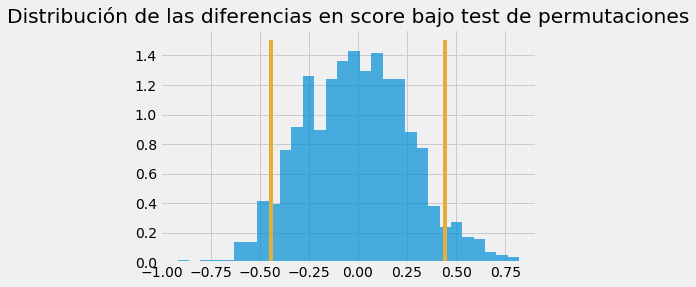

In [16]:
plot_test(T, Ts, 'Distribución de las diferencias en score bajo test de permutaciones')

¿Cuan certero es el test? Dado que tenemos el DGP podemos simular distintos resultados y obtener un p-valor agregado.

In [17]:
def simulate_stat(dgp, compute_stat, K=1000):
    T = compute_stat(dgp())
    T_sim = []
    for k in range(K):
        data = dgp(seed=k)
        T_sim += [compute_stat(data)]
    print(f"The p-value is {sum(np.abs(T_sim) >= np.abs(T))/K}")
    return np.array(T_sim)

In [18]:
T_sim = simulate_stat(generate_data_gender, compute_score_diff)

The p-value is 0.077


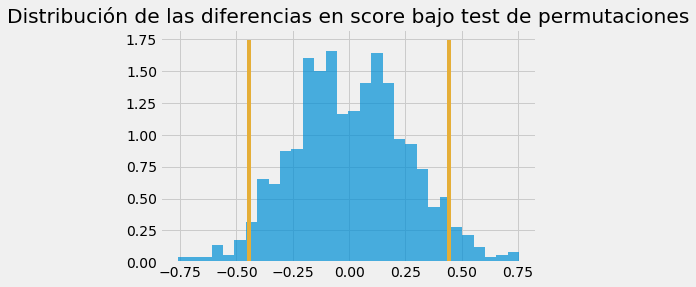

In [19]:
plot_test(T, T_sim, 'Distribución de las diferencias en score bajo test de permutaciones')

### c. Test de Permutaciones vs T-Tests

1. Permutation test advantages:

does not make distributional assumptions
not sensible to outliers
can be computed also for statistics whose distribution is not known

2. Permutation test disadvantages:

computationally intense
very sample-dependent

Ejemplo 2: Supongamos tenemos una muestra de individuos y sus salarios futuros y queremos evaluar si asistir a la universidad es un buena inversión.

In [26]:
# Data generating process
def generate_data_income(N=1000, seed=1):
    np.rand.seed(seed) # Set seed for replicability
    university = np.rand.binomial(1, 0.5, N) # Treatment
    data = pd.DataFrame({"university": university,
                         "income": np.rand.lognormal(university, 2.3, N)})
    return data

In [27]:
data_income = generate_data_income()
data_income.head()

,university,income
0,0,5.305618
1,1,1.289598
2,0,6.507720
3,0,6.019961
4,0,0.034482


[Text(0.5, 1.0, 'Densidad del salario por grupo (Universidad)')]

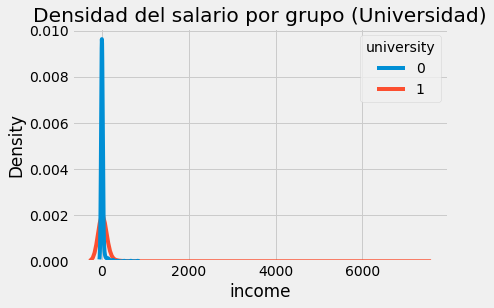

In [28]:
sns.kdeplot(data=data_income, x = data_income.income, hue="university").set(title='Densidad del salario por grupo (Universidad)')

Claramente los ingresos futuros tienen una densidad altamente concentrada en 0 y con una cola muy larga hacia la derecha. ¿Podemos de igual forma construir alguna conclusión respecto a las diferencias en base a D (Universidad)?

In [29]:
def compute_income_diff(data):
    T = np.mean(data.loc[data['university']==1, 'income']) - np.mean(data.loc[data['university']==0, 'income'])
    return T

In [30]:
T = compute_income_diff(data_income)
T

23.546974435985483

In [31]:
T_perm = permutation_test(data_income, permute, 'university', compute_income_diff)


The p-value is 0.011


¿Y si comparamos con un test parametrico?

In [32]:
from scipy.stats import ttest_ind

ttest_ind(data_income.query('university==1')['income'], data_income.query('university==0')['income'])

Ttest_indResult(statistic=1.5589492598056494, pvalue=0.11932542520097006)

Ambos Tests dan resultados muy disimiles. El test T de Student es mucho mas conservador y no permite rechazar la hipotesis nula. La principal razon es el skewness de la data (poca simetria), el test t es atlamente sensible a outliers y por ende computa una varianza enorme dados los pocos data points (altos ingresos) que aparecen en las colas.

EXTRA: The permutation test can further address the problem of a skewed outcome distribution by using a test statistic that is more sensible to outliers. Let’s perform the permutation test using the trimmed mean instead of the mean.

In [33]:
from scipy.stats import trim_mean

def compute_income_mediandiff(data):
    T = np.median(data.loc[data['university']==1, 'income']) - np.median(data.loc[data['university']==0, 'income'])
    return T

In [34]:
T_perm = permutation_test(data_income, permute, 'university', compute_income_mediandiff)

The p-value is 0.0


¿Que pasa con O(N) entre ambos tests?

In [35]:
import time

# No replacement
start = time.time()
permutation_test(data_income, permute, 'university', compute_income_diff)
print(f"Elapsed time without replacement: {time.time() - start}")

# Replacement
start = time.time()
ttest_ind(data_income.query('university==1')['income'], data_income.query('university==0')['income'])
print(f"Elapsed time with replacement: {time.time() - start}")

The p-value is 0.016
Elapsed time without replacement: 1.1349332332611084
Elapsed time with replacement: 0.004987478256225586


##### Ordinary least squares Example: Online Regression 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
%matplotlib inline

Suppose, for example, that we were a fin-tech company. We have designed a new user interface (UI) for our mobile application and we would like to understand whether it slows down our transaction. In order to estimate the causal effect of the new UI on transaction speed, we plan to run an A/B test or randomized controlled trial. Then we analyze the results using a simple linear model and a model which includes a control feature (connection latency)

In [90]:
def generate_data(N=1000, seed=0):
        np.random.seed(seed)
        
        # Connection speed
        connection = np.random.lognormal(3, 1, N)
        
        # Treatment assignment
        treated = np.random.binomial(1, 0.5, N)
        
        # Transfer speed
        #spend = np.minimum(np.random.lognormal(1 + treated + 0.1*np.sqrt(balance), 2, N), balance)
        speed = np.minimum(np.random.exponential(10 + 4*treated - 0.5*np.sqrt(connection), N), connection)
        
        # Generate the dataframe
        df = pd.DataFrame({'c': [1]*N, 'treated': treated,  
                           'connection': np.round(connection,2), 
                           'speed': np.round(speed,2)})

        return df

In [103]:
df = generate_data()
df

,c,treated,connection,speed
0,1,1,117.22,34.02
1,1,1,29.97,3.18
2,1,1,53.45,12.82
3,1,1,188.84,5.01
4,1,1,130.00,5.41
...,...,...,...,...
995,1,1,30.35,9.21
996,1,1,16.47,13.71
997,1,1,22.07,2.04
998,1,1,6.38,6.38


In [93]:
baseline_model = smf.ols('speed ~ treated', data=df).fit(cov_type='HC3')
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     30.13
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           5.12e-08
Time:                        23:23:15   Log-Likelihood:                -3277.8
No. Observations:                1000   AIC:                             6560.
Df Residuals:                     998   BIC:                             6569.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0531      0.251     24.139      0.000       5.562       6.545
treated        2.2061      0.402      5.489      0.000       1.418       2.994
==============================================================================
Omnibus:                      392.097   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1838.840
Skew:                           1.784   Prob(JB):                         0.00
Kurtosis:                       8.603   Cond. No.                         2.68
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [94]:
controlled_model = smf.ols('speed ~ treated + connection', data=df).fit(cov_type='HC3')
controlled_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     15.05
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           3.64e-07
Time:                        23:23:23   Log-Likelihood:                -3277.5
No. Observations:                1000   AIC:                             6561.
Df Residuals:                     997   BIC:                             6576.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9334      0.286     20.762      0.000       5.373       6.493
treated        2.1894      0.400      5.477      0.000       1.406       2.973
connection     0.0041      0.005      0.799      0.424      -0.006       0.014
==============================================================================
Omnibus:                      389.150   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1806.592
Skew:                           1.773   Prob(JB):                         0.00
Kurtosis:                       8.548   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

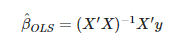

In [95]:
def xy_from_df(df, r0, r1):
    return df.iloc[r0:r1,:3].to_numpy(), df.iloc[r0:r1,3].to_numpy()

In [96]:
from numpy.linalg import inv

X, Y = xy_from_df(df, 0, df.shape[0])
inv(X.T @ X) @ X.T @ Y

array([5.93337564e+00, 2.18935210e+00, 4.11161163e-03])

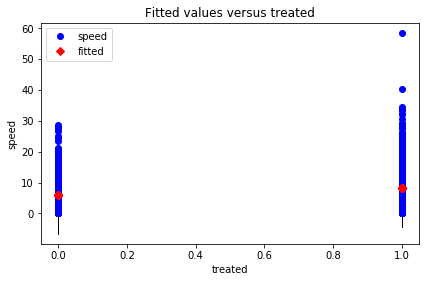

In [102]:
import statsmodels.api as sm
fig = sm.graphics.plot_fit(baseline_model, "treated")
fig.tight_layout(pad=1.0)

eval_env: 1


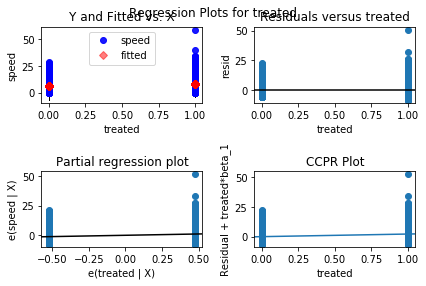

In [107]:
fig = sm.graphics.plot_regress_exog(baseline_model, "treated")
fig.tight_layout(pad=1.0)

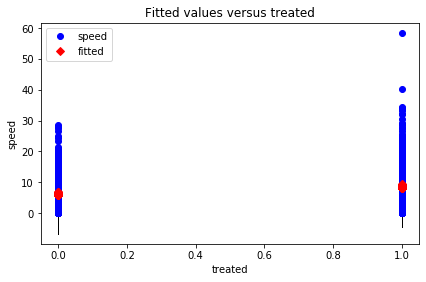

In [105]:
fig = sm.graphics.plot_fit(controlled_model, "treated")
fig.tight_layout(pad=1.0)

eval_env: 1


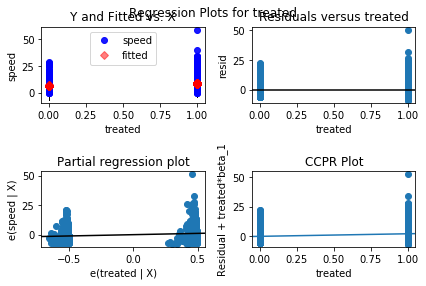

In [106]:
fig = sm.graphics.plot_regress_exog(controlled_model, "treated")
fig.tight_layout(pad=1.0)

### Taking it a step further
We can extend our regression one more time in the following way, see also Lin *Agnostic notes on regression adjustments to experimental data: reexamining freedman's critique*

\begin{equation}
Y_{i,t=1} = \beta_0 + \beta_{\delta} D_i + \beta_1 X_1 + \beta_2 X_2 + \beta_{3} D_i (X_1 - \bar{X}_1) + \beta_{4} D_i (X_2 - \bar{X}_2) + \varepsilon_i,
\end{equation}

In [110]:
df['centered_connection'] = df['connection'] - df['connection'].mean()

In [112]:
controlled2_model = smf.ols('speed ~ treated + connection + treated:centered_connection', data=df).fit(cov_type='HC3')
controlled2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     10.52
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           8.11e-07
Time:                        23:35:42   Log-Likelihood:                -3277.5
No. Observations:                1000   AIC:                             6563.
Df Residuals:                     996   BIC:                             6583.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       5.9262      0.291     20.332      0.000       5.355       6.498
treated                         2.1891      0.401      5.458      0.000       1.403       2.975
connection                      0.0044      0.006      0.704      0.481      -0.008       0.016
treated:centered_connection    -0.0004      0.010     -0.040      0.968      -0.019       0.019
==============================================================================
Omnibus:                      389.237   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1807.686
Skew:                           1.773   Prob(JB):                         0.00
Kurtosis:                       8.550   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""